# Chargement des packages

In [1]:

# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
import joblib # Pour stocker le modèle

# Base de données Diabetes

La base de données "Diabetes" est disponible sur [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database). Cette base de données contient des informations sur des patientes féminines âgées d'au moins 21 ans et provenant de populations amérindiennes Pima, qui ont été examinées pour déterminer s'ils avaient un diabète de type 2. Les caractéristiques incluent des mesures telles que la taille, le poids, l'âge, le nombre de grossesses, la pression artérielle, etc.

## Contenu de la base de données

La base de données contient les colonnes suivantes :

- `Pregnancies` : nombre de grossesses
- `Glucose` : concentration de glucose dans le plasma sanguin à jeun
- `BloodPressure` : pression artérielle diastolique (mm Hg)
- `SkinThickness` : épaisseur du pli cutané tricipital (mm)
- `Insulin` : taux d'insuline sérique de 2 heures (mu U/ml)
- `BMI` : indice de masse corporelle (kg/m²)
- `DiabetesPedigreeFunction` : fonction pedigree du diabète
- `Age` : âge (années)
- `Outcome` : variable cible indiquant si le patient est diabétique (0 = non diabétique, 1 = diabétique)

## Objectif de l'analyse

L'objectif de cette analyse est de construire un modèle de classification pour prédire si une patiente a un diabète de type 2 en fonction de ses caractéristiques cliniques. Cette base de données sera divisée en ensembles d'apprentissage et de test pour entraîner et évaluer les performances du modèle.


# Importation et nettoyage des données

In [2]:
# Chargement des données
diabete=pd.read_csv("data/diabetes.csv")

In [3]:

diabete.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Affichage des informations générales sur le DataFrame
diabete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Diviser la base de données en deux

# Modélisation Random Forest (Forêt Aléatoire)

### Préparation des données pour le modèle

In [5]:
from sklearn.model_selection import train_test_split

X = diabete.drop('Outcome', axis=1)  # Variables prédictives
y = diabete['Outcome']  # Variable cible

# Diviser la base de données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


## Modèle avec optimisation en utilisant les seuil pratique

Lorsque l'on utilise une forêt aléatoire, il est essentiel de faire des choix judicieux pour certains paramètres afin d'optimiser les performances du modèle. Deux paramètres importants à considérer sont :

- `max_features` : Il s'agit de la profondeur maximale de chaque arbre de décision dans la forêt. Une valeur appropriée pour `max_features` permet de contrôler la complexité du modèle et d'éviter le surajustement (overfitting).

**Une approche courante consiste à fixer `max_features` à la racine carrée du nombre de variables utilisées**. Cela permet de limiter la profondeur des arbres et de prévenir une croissance excessive, tout en maintenant un bon équilibre entre sous-apprentissage et surapprentissage.

- `n_estimators` : Il s'agit du nombre d'arbres de décision dans la forêt aléatoire. Un nombre suffisamment grand d'arbres permet d'améliorer les performances du modèle. Cependant, il est important de noter que l'augmentation de `n_estimators` entraîne également une augmentation du temps de calcul. Dans la pratique, on cherche à trouver un compromis entre les performances du modèle et le temps de calcul disponible. 


**Des études empiriques ont montré que l'ajout d'arbres après un certain point n'apporte que des gains marginaux en termes de performance**.

En ajustant ces paramètres de manière appropriée, on peut obtenir une forêt aléatoire bien équilibrée et performante pour la tâche donnée.


### Entrainement du modèle

In [7]:

from sklearn.ensemble import RandomForestClassifier

# Calculer le nombre maximum de variables (max_features) à la racine carrée
max_features = int(np.sqrt(X.shape[1]))

# Créer la forêt aléatoire avec les hyperparamètres fixés
random_forest = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42,oob_score=True)

# Entraîner le modèle sur les données d'entraînement
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_features=2, oob_score=True, random_state=42)

### Prédiction sur les bases train et test

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

# Prédire les classes sur les ensembles d'entraînement et de test
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)


### Performances du modèle

In [10]:

# Calculer les mesures de performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

# Créer le tableau d'évaluation des performances
performance_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall'],
    'Ensemble d\'entraînement': [train_accuracy, train_auc, train_recall],
    'Ensemble de test': [test_accuracy, test_auc, test_recall]
})

# Afficher le tableau d'évaluation des performances
print(performance_table)


   Métrique  Ensemble d'entraînement  Ensemble de test
0  Accuracy                      1.0          0.720779
1       AUC                      1.0          0.697980
2    Recall                      1.0          0.618182


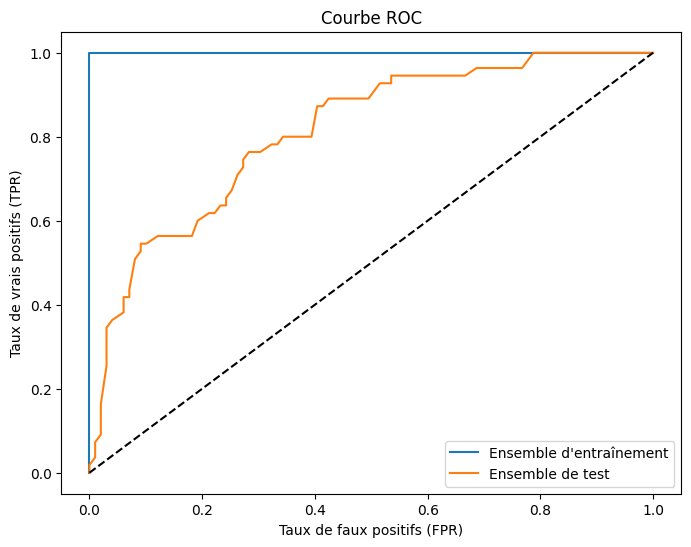

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Obtenir les scores de probabilité pour les classes positives
y_train_prob = random_forest.predict_proba(X_train)[:, 1]
y_test_prob = random_forest.predict_proba(X_test)[:, 1]

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR)
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)

# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label='Ensemble d\'entraînement')
plt.plot(test_fpr, test_tpr, label='Ensemble de test')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()


### Importance des variables

Importance des variables :
                   Variable  Importance
0                   Glucose    0.258864
1                       BMI    0.169984
2                       Age    0.140931
3  DiabetesPedigreeFunction    0.123768
4             BloodPressure    0.088134
5               Pregnancies    0.076551
6                   Insulin    0.076122
7             SkinThickness    0.065646



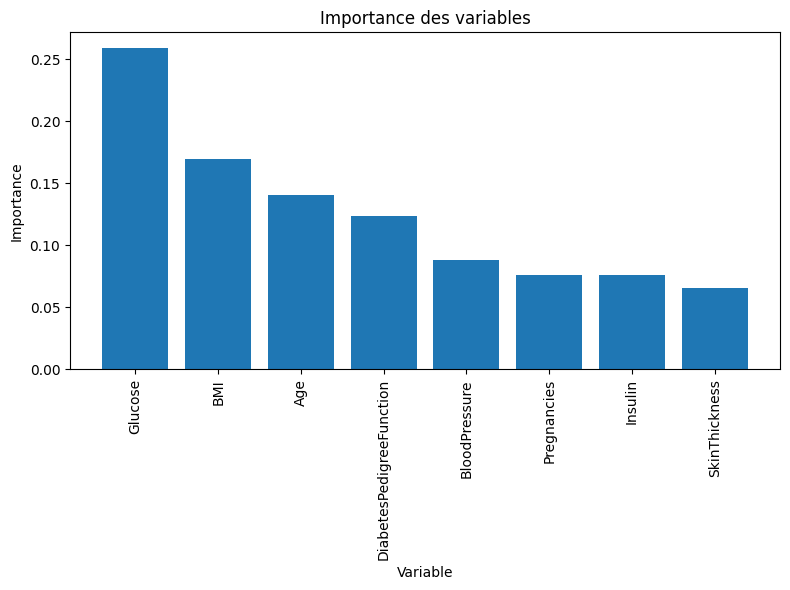

In [12]:
# Obtenir l'importance des variables
importance = random_forest.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Importance des variables')
plt.tight_layout()
plt.show()

In [13]:
# Enregistrer le modèle
joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']